In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!unzip /content/drive/MyDrive/internship/material_corrosion/DATA_SET_FOR_RELEASE_CORROSION.zip -d /content/drive/MyDrive/internship/material_corrosion/

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 extracting: /content/drive/MyDrive/internship/material_corrosion/DATA_SET_FOR_RELEASE/renamed/cross_val_10/val/8/I179_steel_mill-finish_spray-zinc-phosphate-wo-chrome-seal_MIL-DTL-53022_MIL-DTL-53039.jpg  
 extracting: /content/drive/MyDrive/internship/material_corrosion/DATA_SET_FOR_RELEASE/renamed/cross_val_10/val/8/I209_steel_mill-finish_chromated-wash-primer_MIL-DTL-53022_MIL-DTL-53039.jpg  
 extracting: /content/drive/MyDrive/internship/material_corrosion/DATA_SET_FOR_RELEASE/renamed/cross_val_10/val/8/I214_steel-(high-hard)_abrasive-blasted_spray-zinc-phosphate-w-chrome-seal_MIL-DTL-53022_MIL-DTL-53039.jpg  
 extracting: /content/drive/MyDrive/internship/material_corrosion/DATA_SET_FOR_RELEASE/renamed/cross_val_10/val/8/I221_steel-(high-hard)_abrasive-blasted_immersion-zinc-phosphate-w-chrome-seal_MIL-DTL-53022_MIL-DTL-53039.jpg  
 extracting: /content/drive/MyDrive/internship/material_corrosion/DATA_SET_FOR_RELEASE/renamed/cross_val_10/val/8/

# Data Preprocessing and Augmentation

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

for fold in range(1, 11):
  train_folder = f'/content/drive/MyDrive/internship/material_corrosion/DATA_SET_FOR_RELEASE/renamed/cross_val_{fold}/train'
  val_folder = f'/content/drive/MyDrive/internship/material_corrosion/DATA_SET_FOR_RELEASE/renamed/cross_val_{fold}/val'

  train_dataset = datasets.ImageFolder(root=train_folder, transform=train_transform)
  val_dataset = datasets.ImageFolder(root=val_folder, transform=val_transform)

  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

  print(f"Fold {fold}:")
  print(f"  Training set size: {len(train_loader.dataset)}")
  print(f"  Validation set size: {len(val_loader.dataset)}")


Fold 1:
  Training set size: 479
  Validation set size: 61
Fold 2:
  Training set size: 479
  Validation set size: 61
Fold 3:
  Training set size: 479
  Validation set size: 61
Fold 4:
  Training set size: 479
  Validation set size: 61
Fold 5:
  Training set size: 479
  Validation set size: 61
Fold 6:
  Training set size: 479
  Validation set size: 61
Fold 7:
  Training set size: 479
  Validation set size: 61
Fold 8:
  Training set size: 479
  Validation set size: 61
Fold 9:
  Training set size: 479
  Validation set size: 61
Fold 10:
  Training set size: 479
  Validation set size: 61


# ResNet-18

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(train_loader, model, criterion, optimizer, device):
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0

  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    running_loss += loss.item()

  epoch_loss = running_loss / len(train_loader)
  epoch_acc = 100 * correct / total
  return epoch_loss, epoch_acc

def validate_model(val_loader, model, criterion, device):
  model.eval()
  running_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
      for inputs, labels in val_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          loss = criterion(outputs, labels)

          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          running_loss += loss.item()

  epoch_loss = running_loss / len(val_loader)
  epoch_acc = 100 * correct / total
  return epoch_loss, epoch_acc

# Fine Tuning and Focal Loss

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from collections import Counter
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Step 1: Calculate class weights
def calculate_class_weights(train_loader):
    class_counts = Counter()
    for inputs, labels in train_loader:
        labels = labels.numpy()
        class_counts.update(labels)

    total_samples = sum(class_counts.values())

    class_weights = {class_id: total_samples / count for class_id, count in class_counts.items()}

    total_weight = sum(class_weights.values())
    normalized_weights = {class_id: weight / total_weight for class_id, weight in class_weights.items()}

    return normalized_weights

# Step 2: Modify the training function to use weighted loss
def train_model(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_model(val_loader, model, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss.item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [ ]:
num_epochs = 30
for fold in range(1, 11):
    print(f"\nTraining for Fold {fold}...")

    train_loader = DataLoader(datasets.ImageFolder(root=train_folder, transform=transform_train), batch_size=32, shuffle=True)  # Apply transform here
    val_loader = DataLoader(datasets.ImageFolder(root=val_folder, transform=transform_val), batch_size=32, shuffle=False)  # Apply transform here

    class_weights = calculate_class_weights(train_loader)
    weights = torch.tensor([class_weights[i] for i in range(5)], dtype=torch.float32).to(device)

    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 5)
    model.to(device)

    # Freeze all layers except the final fully connected layer
    for param in model.parameters():
        param.requires_grad = False  # Freeze all layers

    # Unfreeze the final fully connected layer to allow fine-tuning
    for param in model.fc.parameters():
        param.requires_grad = True

    # Unfreeze some layers (e.g., layers before the final fully connected layer)
    for param in model.layer4.parameters():
        param.requires_grad = True

    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=0.0001)

    criterion = nn.CrossEntropyLoss(weight=weights)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train_loss, train_acc = train_model(train_loader, model, criterion, optimizer, device)
        print(f"  Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%")

        val_loss, val_acc = validate_model(val_loader, model, criterion, device)
        print(f"  Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

        # Step the scheduler
        scheduler.step()

    torch.save(model.state_dict(), f'/content/drive/MyDrive/internship/material_corrosion/resnet18_fold_{fold}_fine_tuned.pth')
    print(f"Fold {fold} completed.")


Training for Fold 1...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 198MB/s]


Epoch 1/30
  Training Loss: 1.2749, Training Accuracy: 54.70%
  Validation Loss: 1.8694, Validation Accuracy: 60.66%
Epoch 2/30
  Training Loss: 0.9018, Training Accuracy: 63.47%
  Validation Loss: 1.3034, Validation Accuracy: 60.66%
Epoch 3/30
  Training Loss: 0.7874, Training Accuracy: 65.76%
  Validation Loss: 1.3469, Validation Accuracy: 62.30%
Epoch 4/30
  Training Loss: 0.6766, Training Accuracy: 71.82%
  Validation Loss: 0.8648, Validation Accuracy: 70.49%
Epoch 5/30
  Training Loss: 0.6813, Training Accuracy: 70.98%
  Validation Loss: 0.5511, Validation Accuracy: 80.33%
Epoch 6/30
  Training Loss: 0.7169, Training Accuracy: 68.68%
  Validation Loss: 0.7202, Validation Accuracy: 72.13%
Epoch 7/30
  Training Loss: 0.6506, Training Accuracy: 72.86%
  Validation Loss: 0.6279, Validation Accuracy: 72.13%
Epoch 8/30
  Training Loss: 0.5606, Training Accuracy: 75.57%
  Validation Loss: 0.6546, Validation Accuracy: 73.77%
Epoch 9/30
  Training Loss: 0.6247, Training Accuracy: 75.78%
  

# Model Evaluation

In [ ]:
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for fold in range(1, 11):
    print(f"Evaluating for Fold {fold}...")

    model = models.resnet18()
    model.fc = nn.Linear(model.fc.in_features, 5)
    model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/resnet18_fold_{fold}_fine_tuned.pth'))
    model.to(device)
    model.eval()

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_folder = f'/content/drive/MyDrive/internship/material_corrosion/DATA_SET_FOR_RELEASE/renamed/cross_val_{fold}/val'
    val_dataset = datasets.ImageFolder(root=val_folder, transform=val_transform)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Calculate accuracy for the current fold
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy for Fold {fold}: {accuracy * 100:.2f}%")


Evaluating for Fold 1...


<ipython-input-8-51c6de951760>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/resn

Accuracy for Fold 1: 88.52%
Evaluating for Fold 2...


<ipython-input-8-51c6de951760>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/resn

Accuracy for Fold 2: 98.36%
Evaluating for Fold 3...


<ipython-input-8-51c6de951760>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/resn

Accuracy for Fold 3: 88.52%
Evaluating for Fold 4...


<ipython-input-8-51c6de951760>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/resn

Accuracy for Fold 4: 83.61%
Evaluating for Fold 5...


<ipython-input-8-51c6de951760>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/resn

Accuracy for Fold 5: 90.16%
Evaluating for Fold 6...


<ipython-input-8-51c6de951760>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/resn

Accuracy for Fold 6: 81.97%
Evaluating for Fold 7...


<ipython-input-8-51c6de951760>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/resn

Accuracy for Fold 7: 88.52%
Evaluating for Fold 8...


<ipython-input-8-51c6de951760>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/resn

Accuracy for Fold 8: 90.16%
Evaluating for Fold 9...


<ipython-input-8-51c6de951760>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/resn

Accuracy for Fold 9: 86.89%
Evaluating for Fold 10...


<ipython-input-8-51c6de951760>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/resn

Accuracy for Fold 10: 81.97%


# Metrics

Accuracy

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.820


Precision, Recall, F1-Score

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
report = classification_report(all_labels, all_preds, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
print(report)

              precision    recall  f1-score   support

     Class 1       1.00      0.75      0.86        12
     Class 2       0.83      0.83      0.83        12
     Class 3       0.64      0.69      0.67        13
     Class 4       0.83      0.83      0.83        12
     Class 5       0.86      1.00      0.92        12

    accuracy                           0.82        61
   macro avg       0.83      0.82      0.82        61
weighted avg       0.83      0.82      0.82        61



Confusion Matrix

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
report = classification_report(all_labels, all_preds, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 9  1  2  0  0]
 [ 0 10  2  0  0]
 [ 0  1  9  2  1]
 [ 0  0  1 10  1]
 [ 0  0  0  0 12]]


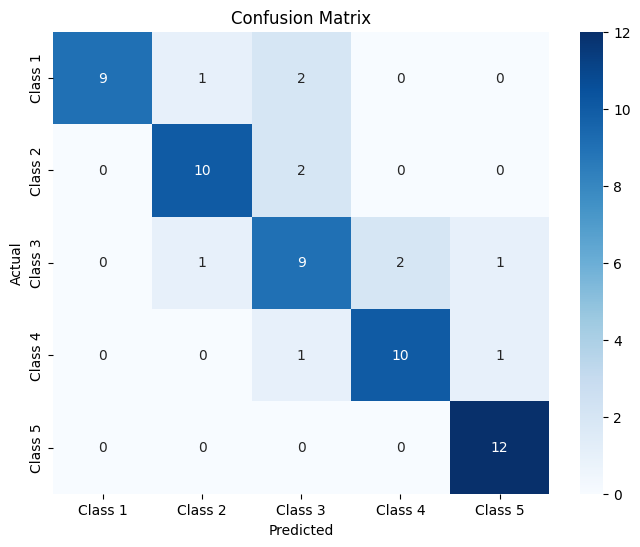

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'], yticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Model Testing

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dir = '/content/drive/MyDrive/internship/material_corrosion/DATA_SET_FOR_RELEASE/renamed/test'
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

all_preds = []
all_labels = []

for fold in range(1, 11):
    print(f"Evaluating Fold {fold}...")

    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 5)
    model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/resnet18_fold_{fold}_fine_tuned.pth'))
    model.eval()
    model.to(device)

    fold_preds = []
    fold_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            fold_preds.extend(preds.cpu().numpy())
            fold_labels.extend(labels.cpu().numpy())

    all_preds.extend(fold_preds)
    all_labels.extend(fold_labels)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds)

print(f"Test Accuracy (averaged over 10 folds): {accuracy*100:.2f}%")
print(f"Precision (averaged over 10 folds): {precision:.2f}")
print(f"Recall (averaged over 10 folds): {recall:.2f}")
print(f"F1 Score (averaged over 10 folds): {f1:.2f}")
print("Confusion Matrix (averaged over 10 folds):")
print(cm)

Evaluating Fold 1...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-13-1f77ad52e79e>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Evaluating Fold 2...
Evaluating Fold 3...
Evaluating Fold 4...
Evaluating Fold 5...
Evaluating Fold 6...
Evaluating Fold 7...
Evaluating Fold 8...
Evaluating Fold 9...
Evaluating Fold 10...
Test Accuracy (averaged over 10 folds): 74.67%
Precision (averaged over 10 folds): 0.74
Recall (averaged over 10 folds): 0.75
F1 Score (averaged over 10 folds): 0.73
Confusion Matrix (averaged over 10 folds):
[[102  14   4   0   0]
 [ 36  56  18   1   9]
 [  1  11  67  34   7]
 [  0   0   5 114   1]
 [  0   0   0  11 109]]


# Save best Fold's Model

In [ ]:
import torch
from sklearn.metrics import accuracy_score

accuracies = []

model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, 5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def evaluate_model(model, test_loader):
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

for fold in range(1, 11):
    print(f"Evaluating for Fold {fold}...")

    model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/resnet18_fold_{fold}_fine_tuned.pth'))
    model.eval()

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_folder = f'/content/drive/MyDrive/internship/material_corrosion/DATA_SET_FOR_RELEASE/renamed/cross_val_{fold}/val'
    val_dataset = datasets.ImageFolder(root=val_folder, transform=val_transform)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    accuracy = evaluate_model(model, val_loader)
    accuracies.append(accuracy)

# Find the fold with the highest accuracy
best_fold = accuracies.index(max(accuracies)) + 1
print(f"Best fold: {best_fold} with accuracy: {accuracies[best_fold - 1] * 100:.2f}%")


Evaluating for Fold 1...


<ipython-input-14-8ccb95c914d7>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/res

Evaluating for Fold 2...


<ipython-input-14-8ccb95c914d7>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/res

Evaluating for Fold 3...


<ipython-input-14-8ccb95c914d7>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/res

Evaluating for Fold 4...


<ipython-input-14-8ccb95c914d7>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/res

Evaluating for Fold 5...


<ipython-input-14-8ccb95c914d7>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/res

Evaluating for Fold 6...


<ipython-input-14-8ccb95c914d7>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/res

Evaluating for Fold 7...


<ipython-input-14-8ccb95c914d7>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/res

Evaluating for Fold 8...


<ipython-input-14-8ccb95c914d7>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/res

Evaluating for Fold 9...


<ipython-input-14-8ccb95c914d7>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/res

Evaluating for Fold 10...


<ipython-input-14-8ccb95c914d7>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/content/drive/MyDrive/internship/material_corrosion/res

Best fold: 2 with accuracy: 98.36%


In [ ]:
# Save the best model based on the highest accuracy
best_model_path = f'/content/drive/MyDrive/internship/material_corrosion/resnet18_fold_{best_fold}_fine_tuned.pth'

best_model = models.resnet18(pretrained=False, num_classes=5)

best_model.load_state_dict(torch.load(best_model_path))
torch.save(best_model.state_dict(), 'final_corrosion_model.pth')

<ipython-input-17-63de73d4eed0>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path))


In [ ]:
# Load the final model for deployment
model = models.resnet18(pretrained=False, num_classes=5)
model.load_state_dict(torch.load('final_corrosion_model.pth'))
model.eval()


<ipython-input-19-6b8382bc8260>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('final_corrosion_model.pth'))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
torch.save(best_model.state_dict(), '/content/final_corrosion_model.pth')
from google.colab import files
files.download('/content/final_corrosion_model.pth')
